In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import re
import seaborn as sns
from itertools import product
sys.path.append("/home/yanhu/DddA/DddA/tdac_seq/")
from ddda_dataset import *
from utils import *
import pickle 
from Bio.Seq import Seq
import scipy.stats as ss
%matplotlib inline

In [2]:
# Create folder for saving plots
replicate = "HJR244_34_NoDddA"
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
if not os.path.exists(plot_dir):
    os.system("mkdir " + plot_dir)

In [24]:
# Create a dictionary for reference regions
ref_range_dict = {
    'HJR244': ('chr11', 5279265, 5282582)
}

# Initialize ddda_dataset
ddda_data = ddda_dataset(
    ID = replicate, 
    region_dict = ref_range_dict, 
    genome_file = "/home/yanhu/data/DddA/shared/refGenomes/hg38.fa", 
    fastq_file = "/home/yanhu/data/DddA/HJR244/fastqs/" + replicate + "/merged.fastq.gz", 
    working_dir = "/home/yanhu/data/DddA/HJR244/"
)

# Load DddA bias model
bias_model_path = "/home/yanhu/data/DddA/HJR245/bias_dict.pkl"
ddda_data.load_bias_model(bias_model_path)

# Align reads
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold,
    ABE_edits = True
)

# Compute a read-by-position matrix of deletion labels
locus = "HJR244"
del_matrix = ddda_data.del_dict[locus]

Loading reference genome
Extracting sequences for each locus
Computing sequence bias


100%|███████████████████████████████████| 72092/72092 [00:21<00:00, 3411.32it/s]


65974 reads aligned. 6118 reads unaligned


### Identify target sites of sgRNAs

(1000.0, 2000.0)

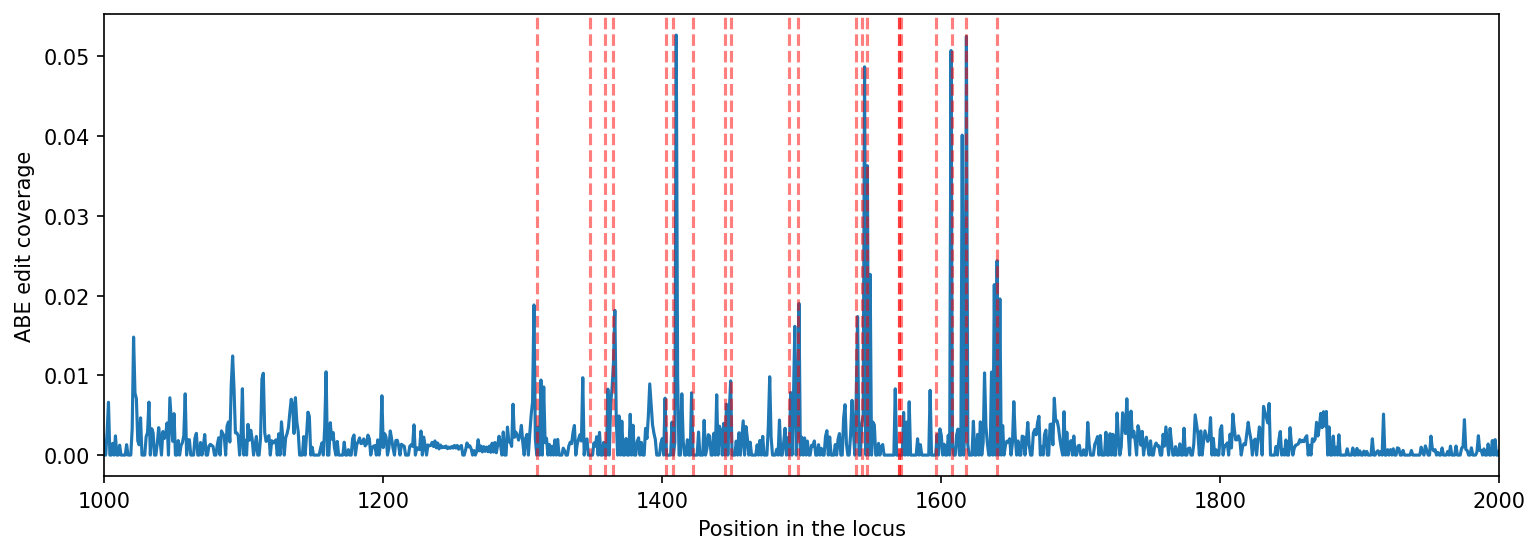

In [25]:
# Specify locus of interest
locus = "HJR244"

# Load sgRNA sequences
sgRNAs = pd.read_csv("/home/yanhu/data/DddA/HJR244/sgRNA.tsv", sep="\t", header=None)
sgRNAs.columns = ["ID", "sequence"]

# Get sequence of the target locus
ref_seq = ddda_data.ref_seq_dict[locus]

# Find sgRNA positions in the target locus
target_sites = []
target_strands = []
for i, row in sgRNAs.iterrows():
    guide_seq_forward = row["sequence"].upper()
    guide_seq_reverse = str(Seq(guide_seq_forward).reverse_complement())
    forward_match = ref_seq.find(guide_seq_forward)
    reverse_match = ref_seq.find(guide_seq_reverse)
    if forward_match >= 0 and reverse_match == -1:
        targte_site = forward_match + 5 
        target_strands.append("+")
    elif forward_match == -1 and reverse_match >= 0:
        targte_site = reverse_match + 14
        target_strands.append("-")
    else:
        raise ValueError("No match or multiple matches for sgRNA found in the target locus")
    target_sites.append(targte_site)

# Sort sgRNA ABE edit sites by coordinate
site_order = np.argsort(target_sites)
target_sites = np.array(target_sites)[site_order]
target_strands = np.array(target_strands)[site_order]

# Visualize ABE edit coverage and sgRNA positions
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
ABE_coverage = np.array(np.mean(ddda_data.ABE_edit_dict[locus], axis=0))[0]
plt.figure(dpi=150, figsize=(12, 4))
plt.plot(np.arange(len(ABE_coverage)), ABE_coverage)
for targte_site in target_sites:
    plt.axvline(x = targte_site, color="red", linestyle="dashed", alpha=0.5)
plt.ylabel("ABE edit coverage")
plt.xlabel("Position in the locus")
plt.xlim([1000,2000])

/tmp/ipykernel_130991/11723897.py:7: RuntimeWarning: invalid value encountered in divide
  ratio = ABE_coverage / ABE_coverage_ctrl


(1100.0, 1850.0)

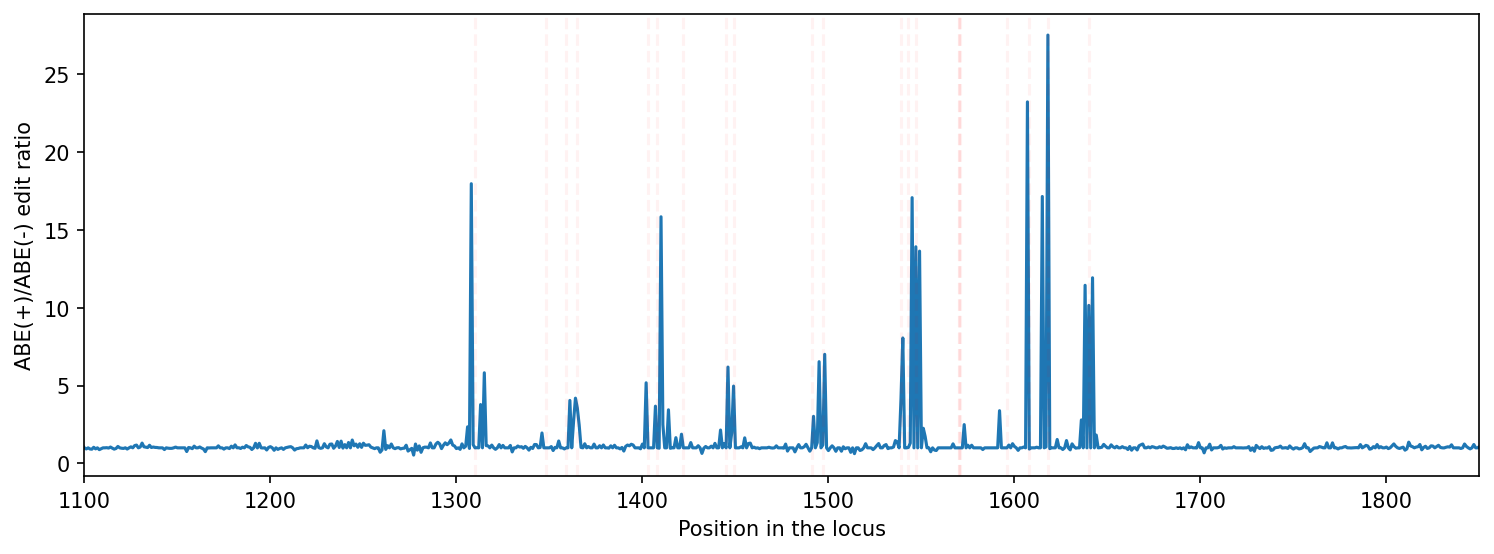

In [26]:
control_path = "/home/yanhu/data/DddA/HJR244/ddda_data_HJR244_1_no_ABE_control.pkl"
with open(control_path, "rb") as f:
    ddda_data_ctrl = pickle.load(f)
ABE_coverage_ctrl = np.array(np.mean(ddda_data_ctrl.ABE_edit_dict[locus], axis=0))[0]

# Calculate ratio of ABE editing rates between ABE(+) and ABE(-) group
ratio = ABE_coverage / ABE_coverage_ctrl
ratio[np.isnan(ratio)] = 1

# Visualize results
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
os.system("mkdir -p " + plot_dir)
plt.figure(dpi=150, figsize=(12, 4))
plt.plot(np.arange(len(ratio)), ratio)
for targte_site in target_sites:
    plt.axvline(x = targte_site, color="red", linestyle="dashed", alpha=0.05)
plt.ylabel("ABE(+)/ABE(-) edit ratio")
plt.xlabel("Position in the locus")
plt.xlim([1100,1850])
#plt.savefig(os.path.join(plot_dir, "ABE_edit_ABE(+)_vs_ABE(-)_ratio_" + replicate + ".pdf"))

In [27]:
# First identify bases within a local window of sgRNA target sites
forward_sgRNA_window = np.unique(np.concatenate(
    [np.arange(target_sites[i] - 3, target_sites[i] + 4) for \
     i in range(len(target_sites)) if target_strands[i] == "+"]
))
reverse_sgRNA_window = np.unique(np.concatenate(
    [np.arange(target_sites[i] - 3, target_sites[i] + 4) for \
     i in range(len(target_sites)) if target_strands[i] == "-"]
))

# Then identify positions of As on both strands
region_seq = ddda_data.ref_seq_dict[locus]
forward_A_pos = [i for i in range(len(region_seq)) if region_seq[i] == "A"]
reverse_A_pos = [i for i in range(len(region_seq)) if region_seq[i] == "T"]

# Find editable As with sgRNAs on the matched strand
forward_editable_pos = np.intersect1d(forward_A_pos, forward_sgRNA_window)
reverse_editable_pos = np.intersect1d(reverse_A_pos, reverse_sgRNA_window)
editable_pos = np.union1d(forward_editable_pos, reverse_editable_pos)

# Also find non-editable (non-target) As
forward_uneditable_pos = np.intersect1d(
    forward_A_pos, np.setdiff1d(reverse_sgRNA_window, forward_sgRNA_window)
)
reverse_uneditable_pos = np.intersect1d(
    reverse_A_pos, np.setdiff1d(forward_sgRNA_window, reverse_sgRNA_window)
)
uneditable_pos = np.union1d(forward_uneditable_pos, reverse_uneditable_pos)

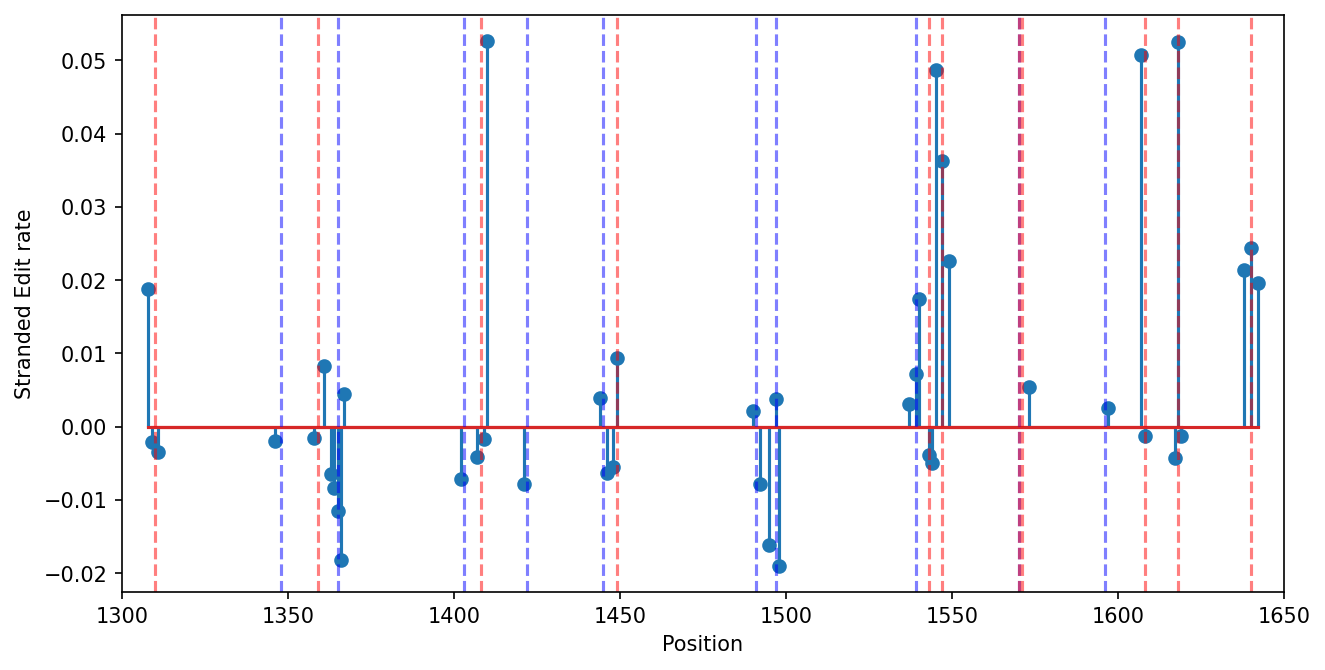

In [28]:
vicinity_pos = np.concatenate(
    [np.arange(target_sites[i] - 2, target_sites[i] + 3) for \
     i in range(len(target_sites))]
)
forward_vicinity_A_pos = np.intersect1d(vicinity_pos, forward_A_pos)
reverse_vicinity_A_pos = np.intersect1d(vicinity_pos, reverse_A_pos)

plt.figure(dpi=150, figsize=(10, 5))
plt.stem(forward_vicinity_A_pos, ABE_coverage[forward_vicinity_A_pos])
plt.stem(reverse_vicinity_A_pos, -1 * ABE_coverage[reverse_vicinity_A_pos])
for targte_site, target_strand in zip(target_sites, target_strands):
    color = "red" if target_strand == "+" else "blue"
    plt.axvline(x = targte_site, color=color, linestyle="dashed", alpha=0.5)
plt.xlim([1300,1650])
plt.ylabel("Stranded Edit rate")
plt.xlabel("Position")

# Save plot
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
os.system("mkdir -p " + plot_dir)
#plt.savefig(os.path.join(plot_dir, "ABE_edit_sgRNA_strand_compare_" + replicate + ".pdf"))
plt.show()

In [29]:
target_A_pos = np.intersect1d(np.where(ratio > 2)[0], editable_pos)

### Calculate impact of ABE edits on accessibility measured by DddA edits

In [30]:
ABE_results = {}

# Compute a read-by-position matrix of ABE edit labels
ABE_matrix = ddda_data.ABE_edit_dict[locus]

# Get strandedness of each read
strands = ddda_data.read_strands[locus]
strand_read_inds = {
    "C_to_T" : np.where(strands == 0)[0],
    "G_to_A" : np.where(strands == 1)[0]
}

ABE_results[replicate] = {}
for A_pos in target_A_pos:

    print("Processing A at position", A_pos)

    ################################################################
    # Select reads with and without ABE edits by the current sgRNA #
    ################################################################

    # Find reads where the sgRNA target site is covered by a editetion
    target_site_edit = np.squeeze(np.array(ABE_matrix[:, A_pos].todense()))
    edited_read_inds = np.where(target_site_edit == 1)[0]
    
    # Only keep reads where positions outside of the vicinity of the sgRNA target site are not editeted
    upstream_filter = np.squeeze(np.array(np.max(ABE_matrix[:, :A_pos], axis=1).todense())) == 0
    downstream_filter = np.squeeze(np.array(np.max(ABE_matrix[:,(A_pos + 1):], axis=1).todense())) == 0
    filter = np.where(upstream_filter & downstream_filter)[0]
    edited_read_inds = np.intersect1d(edited_read_inds, filter)
    
    # Separately, also find reads without any edits as a control
    read_with_edit = np.squeeze(np.array(np.max(ABE_matrix, axis=1).todense()))
    unedited_read_inds = np.where(read_with_edit == 0)[0]

    ###################################
    # Down-sampling and deduplication #
    ###################################

    '''
    # Down-sample the number of reads
    min_num = min(len(edited_read_inds), len(unedited_read_inds), 10000)
    if min_num < 5:
        continue
    print(min_num)
    edited_read_inds = np.random.choice(edited_read_inds, min_num, replace=False)
    unedited_read_inds = np.random.choice(unedited_read_inds, min_num, replace=False)

    # De-duplicate reads
    edited_read_ids = ddda_data.dedup_reads(
        locus = locus, 
        read_ids = np.array(ddda_data.read_ids[locus])[edited_read_inds]
    )
    unedited_read_ids = ddda_data.dedup_reads(
        locus = locus, 
        read_ids = np.array(ddda_data.read_ids[locus])[unedited_read_inds]
    )
    
    # For each read ID, get its index in the full read ID list
    locus_ids = ddda_data.read_ids[locus]
    locus_id_dict = dict(zip(locus_ids, np.arange(len(locus_ids))))
    edited_read_inds = np.array([*map(locus_id_dict.get, edited_read_ids)])
    unedited_read_inds = np.array([*map(locus_id_dict.get, unedited_read_ids)])
    '''

    #################################################################
    # Calculate DddA editing rate for ABE edited and unedited reads #
    #################################################################
    
    ABE_results[replicate][A_pos] = {}
    valid = True
    for strand in  ["C_to_T", "G_to_A"]:

        # Calculate average DddA editing rate on ABE edited reads for both C-to-T and G-to-A strands
        edited_read_inds_stranded = np.intersect1d(edited_read_inds, strand_read_inds[strand])
        print(len(edited_read_inds_stranded))
        if len(edited_read_inds_stranded) == 0:
            valid = False
            break
        ABE_edited_DddA_edits = np.array(np.mean(ddda_data.edit_dict[locus][edited_read_inds_stranded, :], axis=0))[0, :]
        
        
        # Calculate average DddA editing rate on ABE unedited reads for both C-to-T and G-to-A strands
        unedited_read_inds_stranded = np.intersect1d(unedited_read_inds, strand_read_inds[strand])
        print(len(unedited_read_inds_stranded))
        if len(unedited_read_inds_stranded) == 0:
            valid = False
            break
        ABE_unedited_DddA_edits = np.array(np.mean(ddda_data.edit_dict[locus][unedited_read_inds_stranded, :], axis=0))[0, :]
        
        strand_results = {
            "edited_read_inds" : edited_read_inds_stranded,
            "unedited_read_inds" : unedited_read_inds_stranded,
            "ABE_edited_DddA_edits" : ABE_edited_DddA_edits,
            "ABE_unedited_DddA_edits" : ABE_unedited_DddA_edits
        }

        ABE_results[replicate][A_pos][strand] = strand_results
    if not valid:
        del ABE_results[replicate][A_pos]

Processing A at position 1308
48
5189
14
1418
Processing A at position 1313
4
5189
0
Processing A at position 1361
46
5189
14
1418
Processing A at position 1363
5
5189
3
1418
Processing A at position 1364
5
5189
1
1418
Processing A at position 1365
4
5189
1
1418
Processing A at position 1366
13
5189
5
1418
Processing A at position 1402
29
5189
11
1418
Processing A at position 1410
300
5189
98
1418
Processing A at position 1411
11
5189
1
1418
Processing A at position 1442
3
5189
1
1418
Processing A at position 1446
18
5189
4
1418
Processing A at position 1449
61
5189
13
1418
Processing A at position 1492
33
5189
10
1418
Processing A at position 1495
8
5189
3
1418
Processing A at position 1498
54
5189
7
1418
Processing A at position 1540
17
5189
5
1418
Processing A at position 1545
55
5189
25
1418
Processing A at position 1547
8
5189
3
1418
Processing A at position 1549
5
5189
2
1418
Processing A at position 1573
30
5189
5
1418
Processing A at position 1607
346
5189
110
1418
Processing A

In [31]:
# Find sgRNAs shared by both replicates
kept_A_pos = list(ABE_results[replicate].keys())

ABE_effect = {}
for replicate in [replicate]:
    effect_mtx = []
    for A_pos in kept_A_pos:

        # Calculate effect of sgRNA on DddA edits
        CT_ABE_edited_DddA_edits = ABE_results[replicate][A_pos]["C_to_T"]["ABE_edited_DddA_edits"]
        CT_ABE_unedited_DddA_edits = ABE_results[replicate][A_pos]["C_to_T"]["ABE_unedited_DddA_edits"]
        GA_ABE_edited_DddA_edits = ABE_results[replicate][A_pos]["G_to_A"]["ABE_edited_DddA_edits"]
        GA_ABE_unedited_DddA_edits = ABE_results[replicate][A_pos]["G_to_A"]["ABE_unedited_DddA_edits"]
        diff_edits = (CT_ABE_edited_DddA_edits - CT_ABE_unedited_DddA_edits + GA_ABE_edited_DddA_edits - GA_ABE_unedited_DddA_edits) / 2
        diff_edits = np.convolve(diff_edits, np.ones(100), mode="same") / 100
        effect_mtx.append(diff_edits)
        
    ABE_effect[replicate] = np.array(effect_mtx)

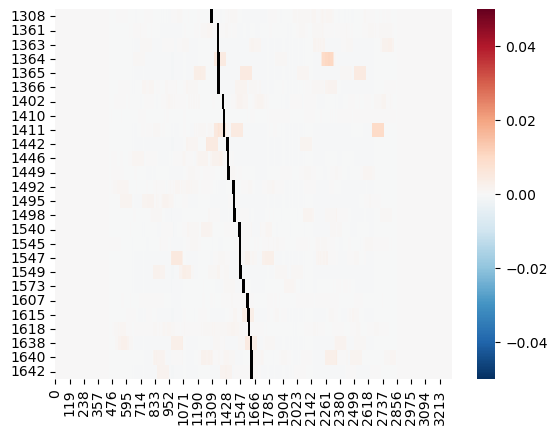

In [32]:
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate

# Generate a mask to visualize location of ABE target sites
ABE_mask = []
locus_len = ABE_effect[replicate].shape[1]
for A_pos in kept_A_pos:
    ABE_vec = np.zeros(locus_len)
    # We use a wide interval mostly to help visualize. Otherwise the line is too thin to see
    ABE_vec[max(0, A_pos - 10):min(A_pos + 10, locus_len)] = 1 
    ABE_mask.append(ABE_vec)
ABE_mask = np.array(ABE_mask) > 0

# Set mask color to be black
import matplotlib as mpl
cmap = mpl.colormaps.get_cmap('RdBu_r')
cmap.set_bad("k")

# Visualize base edit impact using a heatmap
ax = sns.heatmap(
    ABE_effect[replicate], 
    cmap=cmap, vmax=0.05, vmin=-0.05, 
    yticklabels=kept_A_pos,
    mask=ABE_mask)
ax.collections[0].set_rasterized(True)
#plt.savefig(os.path.join(plot_dir, "ABE_single_bp_diff_edit_heatmap_" + replicate + ".pdf"))
plt.show()

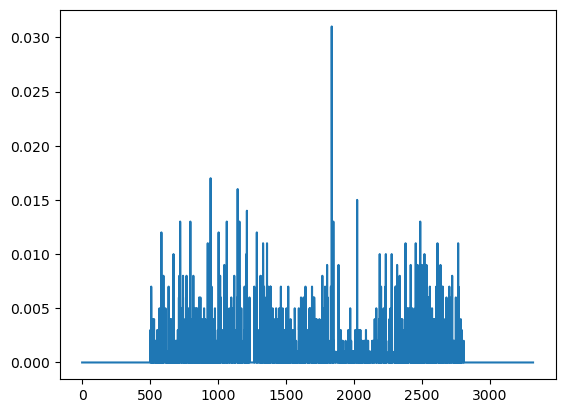

In [33]:
n_reads = len(ddda_data.read_ids[locus])
plt.plot(np.array(np.mean(ddda_data.edit_dict[locus][np.random.choice(np.arange(n_reads), 1000), :], axis=0))[0])